In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import math

%config InlineBackend.figure_format = 'retina'


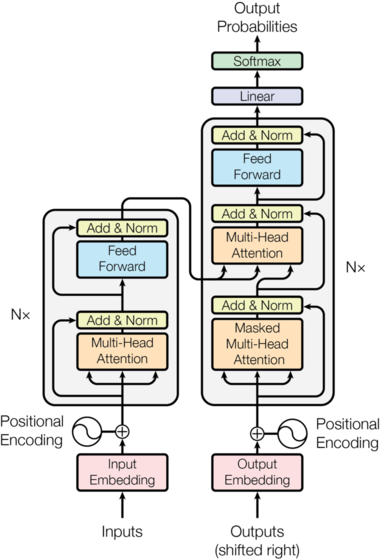

# Input Embedding

## Tokenization

- To transform text data into numerical representations, we need to firstly tokenize the sentence.
    - There're many ways you can tokenize your sentence ( Tokenizing a text is splitting it into words or sub-words, which then are converted to ids through a look-up table) https://huggingface.co/docs/transformers/en/tokenizer_summary

```python

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True)


print(encoded_input)
{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0],
               [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102],
               [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}
```

We can worry about attention_mask later

## Embedding Table Lookup

- Embedding is just a lookup table and we will use one hot encoding to extract the vocab and it's corresponding Embedding vector
- These vectors will be updated as a parameter when model is being trained with gradient based optimization methods
- Use embedding is a common trick in NLP so that we can project high dimensional (1M dim) sparse text data (eg. one-hot encoding) into low dimensional dense numerical representation eg. dim=512

In [2]:
class Embedding(nn.Module):

    def __init__(self, vocab_size, d_k):
        super().__init__()
        torch.manual_seed(0)
        self.emb = nn.Embedding(vocab_size, d_k)
    
    def forward(self, x):
        return self.emb(x)


tokens = "I am good".split()
vocab_size, emb_size = len(tokens), 5
token_emb = Embedding(vocab_size, emb_size)
print(token_emb.emb.weight)

Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845],
        [-1.3986,  0.4033,  0.8380, -0.7193, -0.4033],
        [-0.5966,  0.1820, -0.8567,  1.1006, -1.0712]], requires_grad=True)


```python
Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845],
        [-1.3986,  0.4033,  0.8380, -0.7193, -0.4033],
        [-0.5966,  0.1820, -0.8567,  1.1006, -1.0712]], requires_grad=True)
```

```python
I    ---> [ 1.5410, -0.2934, -2.1788, 0.5684, -1.0845]
am   ---> [-1.3986, 0.4033, 0.8380, -0.7193, -0.4033]
good ---> [-0.5966, 0.1820, -0.8567, 1.1006, -1.0712]
```

Notice that in linear algebra class, we see those 3 embedding vectors as column vector; but in tensorflow and pytorch, we treat them as row vector and stack them together (they are the same thing) but it might be confusing for beginners


I am good Embedding will be something like:
```python
  [
      [ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845]
      [-1.3986,  0.4033,  0.8380, -0.7193, -0.4033]
      [-0.5966,  0.1820, -0.8567,  1.1006, -1.0712]
  ]
```
Notice that I am good is a matrix X shape = (vocab, d_model) or (input_len, d_model), or (seq_len, d_model)

for mini-batch embedding where mini-batch n, then it will be a 3d tensor, where shape = (nbatch, input_len, d_model)

# Positional Encoding

More detail here: <url>

Transformers operate on sequences of tokens (such as words in a sentence) in parallel, without an inherent notion of sequence order. To allow the model to leverage the order of the sequence, positional encodings are introduced. These encodings inject information about the relative or absolute position of tokens within the sequence. 简单来说，位置编码最根本的作用是打破Attention的置换不变性。就是yn
跟key-value的序无关，这跟自然语言的特性不符，所以我们要想办法打破这种不变性。用数据库来类比，没有位置编码的Attention就像是没有时间标签的数据库，检索结果只跟query有关，而位置编码就相当于给数据库的item按顺序打上时间标签，使得检索结果还可以跟item顺序有关。https://kexue.fm/archives/10347



## Common Implementation

A standard approach, as described in the original Transformer paper "Attention Is All You Need," uses sinusoidal functions of different frequencies. Each position $pos$ in the sequence is mapped to a vector of dimension $d_{model}$, where each dimension corresponds to a sine or cosine function. Specifically:

$$
PE_{pos,2i} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

$$
PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

Here, $pos$ is the position of the token in the sequence, $i$ is the index of the dimension, and $d_{model}$ is the dimensionality of the model.

By defining the positional encoding explicitly （显示解）with sine and cosine functions at different frequencies, positions that are close to each other produce similar vectors, while positions that are far apart produce substantially different vectors. This periodicity and smoothness allow the model to extrapolate to positions not seen during training.

## Additional Notes

- Positional encodings do not require parameters to be learned, unlike learned position embeddings, where a set of embeddings are trained for each position.

# Scaled Dot Product Attention

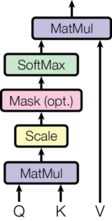

Scaled Dot Product Attention is a fundamental component of the Transformer architecture, widely used in natural language processing and other machine learning tasks. It allows the model to focus on different parts of the input sequence when generating each part of the output sequence.

## Attention Mechanism

The attention mechanism enables the model to weigh the importance of different input elements dynamically. In the context of Transformers, attention is computed using three primary vectors:

- **Query ($\mathbf{Q}$)**: Represents the current token for which attention is being calculated.
- **Key ($\mathbf{K}$)**: Represents the tokens being compared against the query.
- **Value ($\mathbf{V}$)**: Represents the information to be aggregated based on the attention scores.

## Scaled Dot Product Attention Formula

The Scaled Dot Product Attention is computed using the following steps:

1. **Dot Products of Queries and Keys**:
   
   Compute the dot product between the query and all keys to obtain the raw attention scores.

   $$
   \text{Attention Scores} = \mathbf{Q} \cdot \mathbf{K}^\top
   $$

2. **Scaling**:
   
   Scale the attention scores by the square root of the dimensionality of the key vectors ($d_k$) to prevent the gradients from becoming too small during training.

   $$
   \text{Scaled Scores} = \frac{\mathbf{Q} \cdot \mathbf{K}^\top}{\sqrt{d_k}}
   $$

3. **Softmax**:
   
   Apply the softmax function to obtain the attention weights, which represent the probability distribution over the keys.

   $$
   \text{Attention Weights} = \text{softmax}\left(\frac{\mathbf{Q} \cdot \mathbf{K}^\top}{\sqrt{d_k}}\right)
   $$

4. **Weighted Sum of Values**:
   
   Multiply the attention weights by the value vectors to obtain the final output of the attention mechanism.

   $$
   \text{Output} = \text{Attention Weights} \cdot \mathbf{V}
   $$

## Combined Formula

Combining all the steps, the Scaled Dot Product Attention can be succinctly expressed as:

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q} \cdot \mathbf{K}^\top}{\sqrt{d_k}}\right) \mathbf{V}
$$

## Key Components Explained

- **Queries, Keys, and Values**: These are projections of the input embeddings. Typically, they are obtained by multiplying the input by learned weight matrices.

  $$
  \mathbf{Q} = \mathbf{X} \mathbf{W}^Q, \quad \mathbf{K} = \mathbf{X} \mathbf{W}^K, \quad \mathbf{V} = \mathbf{X} \mathbf{W}^V
  $$

  where $\mathbf{W}^Q$, $\mathbf{W}^K$, and $\mathbf{W}^V$ are learnable weight matrices.

- **Scaling Factor $\sqrt{d_k}$**: The scaling factor helps in maintaining the stability of gradients by preventing the dot product values from growing too large, which can push the softmax function into regions with very small gradients. 也就是说其中因子 $\sqrt{d_k}$, 起到调节作用，使得内积不至于太大（太大的话softmax后就非0即1了，不够“soft”了）。

Reminder 

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

$$
\frac{\partial \text{Softmax}(z_i)}{\partial z_j} =
\begin{cases}
\text{Softmax}(z_i) \left(1 - \text{Softmax}(z_i)\right) & \text{if } i = j \\
- \text{Softmax}(z_i) \text{Softmax}(z_j) & \text{otherwise}
\end{cases}
$$

$$
L = -\sum_{i=1}^{K} y_i \log(\text{Softmax}(z_i))
$$




- **Softmax Function**: Converts the scaled attention scores into a probability distribution, ensuring that the weights sum to one and emphasizing the most relevant parts of the input.

## Importance in Transformer Models

Scaled Dot Product Attention is crucial in Transformer models for several reasons:

1. **Parallelization**: Unlike recurrent models, Transformers allow for parallel computation of attention across the entire sequence, leading to significant speedups during training.

2. **Long-Range Dependencies**: The attention mechanism can capture dependencies between distant elements in the sequence effectively, which is essential for tasks like machine translation and text summarization.

3. **Flexibility**: By adjusting the queries, keys, and values, the model can focus on different aspects of the input, enabling nuanced and context-aware representations.

## Summary

Scaled Dot Product Attention is a mechanism that allows models to weigh the relevance of different input elements dynamically. By computing attention scores, scaling them, applying softmax, and aggregating the values, the model can focus on the most pertinent parts of the input for each output element. This mechanism is foundational to the effectiveness of Transformer architectures in various machine learning tasks.




$$
\begin{aligned}
1. & \quad \text{Define the softmax function:} \\
   & \quad \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{k} e^{z_k}} \\
2. & \quad \text{Compute the derivative of softmax with respect to } z_j: \\
   & \quad \frac{\partial \text{softmax}(z_i)}{\partial z_j} = \text{softmax}(z_i) \left( \delta_{ij} - \text{softmax}(z_j) \right) \\
3. & \quad \text{When } z_i \text{ are large, softmax}(z_i) \text{ becomes sparse:} \\
   & \quad \text{softmax}(z_i) \approx 
   \begin{cases}
      1 & \text{if } z_i \text{ is the largest} \\
      0 & \text{otherwise}
   \end{cases} \\
4. & \quad \text{Substitute the sparse softmax into the derivative:} \\
   & \quad \frac{\partial \text{softmax}(z_i)}{\partial z_j} \approx 
   \begin{cases}
      0 & \text{if } i \neq j \\
      1 \times (1 - 1) = 0 & \text{if } i = j
   \end{cases} \\
5. & \quad \text{Therefore, the gradients } \frac{\partial \text{softmax}(z_i)}{\partial z_j} \text{ are very small, leading to diminished gradient flow.}
\end{aligned}
$$

# Gradient of Softmax with Large Inputs (Continued)

$$
\begin{aligned}
6. & \quad \text{When } i \neq j, \text{softmax}(z_i) \approx 0 \text{ and } softmax(z_j) \approx 0, \text{ so:} \\
   & \quad \frac{\partial \text{softmax}(z_i)}{\partial z_j} \approx 0 \times (0 - 0) = 0 \\
7. & \quad \text{Alternatively, if } i \text{ is the index of the maximum } z, \text{ then softmax}(z_i) \approx 1 \text{ and } softmax(z_j) \approx 0 \text{ for } j \neq i, \text{ so:} \\
   & \quad \frac{\partial \text{softmax}(z_i)}{\partial z_j} \approx 1 \times (0 - 0) = 0 \\
8. & \quad \text{In both cases, when } i \neq j, \text{ the gradient } \frac{\partial \text{softmax}(z_i)}{\partial z_j} \text{ is approximately } 0. \\
9. & \quad \text{This results in negligible gradient contributions for non-target indices, leading to diminished gradient flow during backpropagation.}
\end{aligned}
$$


In [3]:
def attention(q, k, v, mask=None, dropout=None):
    # q, k, v (batch input_len, d_k) = (batch, time, channel_size)
    d_k = q.size(-1) # 512

    # k: (batch input_len, d_k) => transpose(-2, -1) => (batch, d_k, input_len)
    # switch last 2nd and last 1st dimension
    # (batch input_len, d_k) * (batch, d_k, input_len) = (batch, input_len, input_len)
    logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        # mask = torch.tensor([1, 0, 2, 3])]
        logits = logits.masked_fill(mask==0, float("-inf")) # # mask==0 -> [F, T, F, F] -> [1, -1e9, 2, 3

    # apply softmax along axis=
    # 2 on row-wise
    attention_score = torch.softmax(logits, dim=-1) # (batch, input_len, input_len)

    if dropout is not None:
        attention_score = dropout(attention_score)

    results = torch.matmul(attention_score, v) # (batch, input_len, input_len) * (batch, input_len, d_k)
    return results, attention_score # (batch, input_len, d_k), (batch, input_len, input_len)

In [4]:
def plot_matrix(input_tensor):
    matrix = input_tensor[0]

    # Convert to NumPy array
    matrix = matrix.numpy()

    # Step 3: Visualize using Matplotlib
    plt.matshow(matrix)  # Use 'gray_r' to display ones as black
    plt.title('Visualization of Subsequent Mask')
    plt.xlabel('Position in Sequence (Key)')
    plt.ylabel('Position in Sequence (Query)')
    plt.colorbar(label='Mask Value')

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            value_as_str = f"{matrix[i, j]:.2f}"
            plt.text(j, i, str(value_as_str), ha='center', va='center', color='white', size=7)
    plt.show()

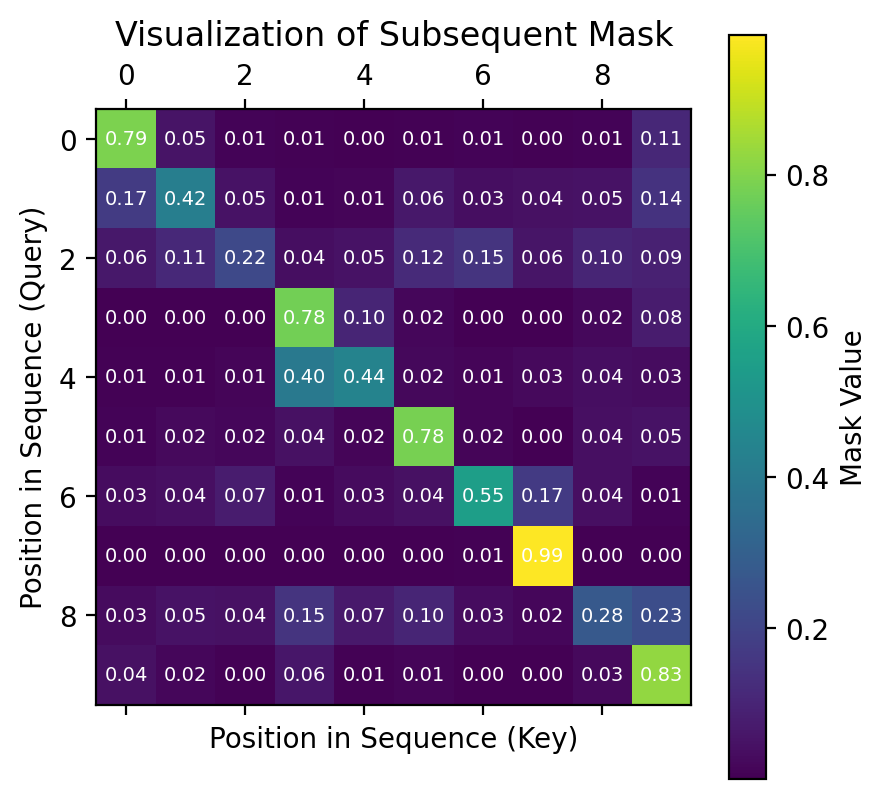

In [5]:
torch.manual_seed(10)
x = torch.randn((1, 10, 10))
results, attention_score = attention(x, x, x)
plot_matrix(attention_score)

# Attention with Mask

Why we need attention with mask?

- Prevents Information Leakage: Masking future tokens ensures that the model cannot "cheat" by looking at the answers during training.
- Handles Variable-Length Sequences: Padding masks allow the model to process sequences of different lengths in batches without interference from padding tokens.
- Enhances Training Stability: By focusing attention only on relevant tokens, the model can learn more effectively and converge faster.

## Source Mask (src mask): 

- Ignoring Padding Tokens: When processing batches of sequences with varying lengths, shorter sequences are padded with $<pad>$ tokens to match the length of the longest sequence in the batch.
Preventing Attention to Padding: Without masking, the attention mechanism might assign importance to these $<pad>$ tokens, which do not carry meaningful information, potentially introducing noise into the model's computations.

```python
# Example for a single sequence
src = ["<sos>", "I", "am", "learning", "<pad>", "<pad>"]
src_mask = [True, True, True, True, False, False]

```

## Target Mask (trg mask): 

- Ignoring Padding Tokens: To ensure that the model doesn't consider \<pad\> tokens when computing attention scores, which could disrupt learning.

```python
# Example for a single sequence
tgt = ["<sos>", "Je", "apprends", "<pad>", "<pad>"]
padding_mask = [True, True, True, False, False]
```


- Maintaining Autoregressive Property: During training, we want the model to predict the next token based only on the previous tokens, not future ones. This is crucial for tasks like language modeling and sequence generation. Subsequent Mask (Causal Mask): A lower triangular matrix that masks out future tokens.
```python

# Subsequent mask for sequence length 5
subsequent_mask = [
    [True, False, False, False, False],
    [True, True, False, False, False],
    [True, True, True, False, False],
    [True, True, True, True, False],
    [True, True, True, True, True]
]

```

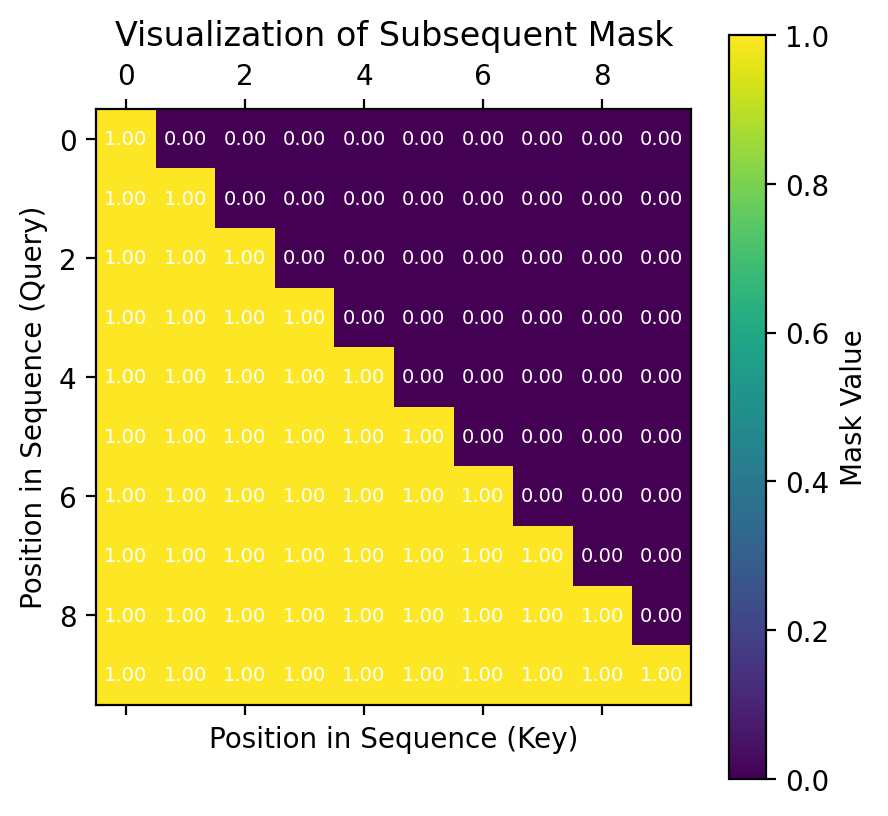

In [6]:
mask = torch.tril(torch.ones((1, 10, 10)), diagonal=0).bool() # lower triangular
plot_matrix(mask)

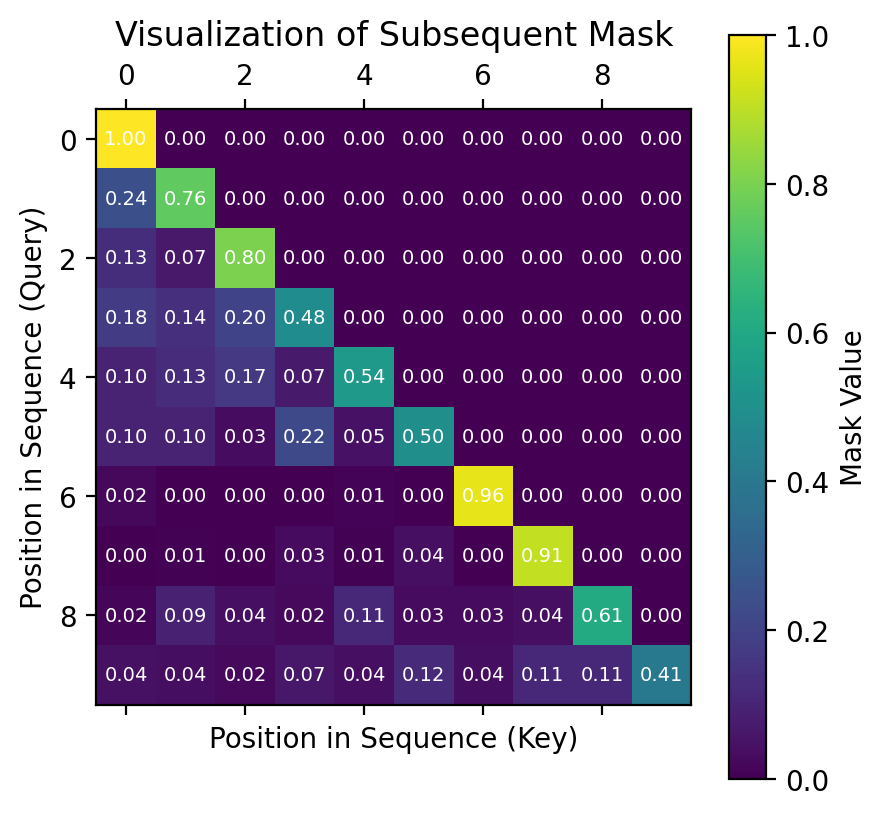

In [7]:
x = torch.randn((1, 10, 10))
mask = torch.tril(torch.ones((1, 10, 10)), diagonal=0).bool() # casual masking: lower triangular
results, masked_attention_score = attention(x, x, x, mask=mask)
plot_matrix(masked_attention_score)

Notice that attention matrix with subsequent (casual) masking + softmax transformation on row, gives use lower triangular looks + all value on diagonal are non-negative, and this means that masked attention is full ranked. This gives model a good ability to represent the meaning of word without too much loss on the information. More detail here:

- https://kexue.fm/archives/9529/comment-page-1#comments
- https://www.zhihu.com/question/588325646

# Multi-Head Attention

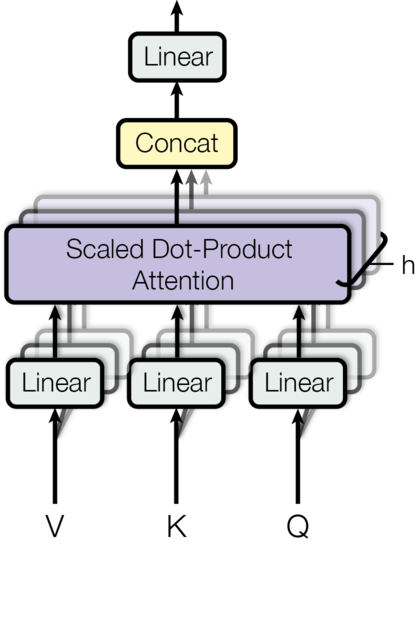


## Multi-Head Attention

To enhance the model's ability to focus on different parts of the input simultaneously, Transformers employ **Multi-Head Attention**, which involves running multiple Scaled Dot Product Attention operations in parallel and then concatenating their outputs.

$$
\text{MultiHead}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Concat}(\text{head}_1, \text{head}_2, \dots, \text{head}_h) \mathbf{W}^O
$$

where each head is computed as:

$$
\text{head}_i = \text{Attention}(\mathbf{Q} \mathbf{W}_i^Q, \mathbf{K} \mathbf{W}_i^K, \mathbf{V} \mathbf{W}_i^V)
$$

and $\mathbf{W}^O$ is a learnable weight matrix.


In [11]:
class MultiHeadAttention(nn.Module):

    def __init__(self, dk=512, h=8):
        self.dk = dk
        self.h = h
        self.d = self.dk // self.h
        self.q_linear = nn.Linear(dk, dk)
        self.k_linear = nn.Linear(dk, dk)
        self.v_linear = nn.Linear(dk, dk)
        self.linear = nn.Linear(dk, dk)

    def forward(self, q, k, v, mask=None):
        n_batch = q.size[0]
        # mask: (batch_size, input_len, input_len)
        if mask is not None:
            mask = mask.unsqueeze(1) #  (batch_size, 1, input_len, input_len)

        # q, k, v: (batch_size, input_len, d_k)
        qk = torch.matmul(q, k.transpose(-1, -2)) # qk: (batch_size, input_len, input_len)
        # q: (batch_size, input_len, h, d_k//h)
        # q: (batch_size, h, input_len, dk//h) # for each batch_size, for each head: ..

        q = q.view(n_batch, -1, self.h, self.d).transpose(-2, -3)
        k = k.view(n_batch, -1, self.h, self.d).transpose(-2, -3)
        v = v.view(n_batch, -1, self.h, self.d).transpose(-2, -3)

        q = self.q_linear(q) # q: (batch, h, input_len, d)
        k = self.k_linear(k) # k: (batch, h, input_len, d)
        v = self.v_linear(v) # v: (batch, h, input_len, d)

        x, self.attn = attention(q, k, v, mask) # x: (batch, h, input_len, d)
        
        x = x.transpose(1, 2)  # x: (batch, input_len, h, d)
        # Incorrect Shape After Direct View:

        # Without transposing, x is of shape [N, h, L, d_k].
        # Applying view(N, -1, h * d_k) would not correctly align the sequence length
        # and would merge the batch, head, and sequence dimensions improperly.
        x.contiguous()
        # we need to merge all the head: put h back to d
        x = x.view(n_batch, -1, self.h * self.d)
        x = self.linear(x)
        return x

# Layer Normalization

Layer normalization is a technique used to normalize the inputs across the features for each data point, improving the training stability and performance of neural networks.

## Formula

The layer normalization process can be described by the following equation:

$$
\text{LayerNorm}(x) = \frac{x - \mu}{\sigma + \epsilon} \cdot \gamma + \beta
$$

where:
$$
\mu = \frac{1}{H} \sum_{i=1}^{H} x_i
$$

$$
\sigma = \sqrt{\frac{1}{H} \sum_{i=1}^{H} (x_i - \mu)^2}
$$

- $x$ is the input vector.
- $\mu$ is the mean of the input.
- $\sigma$ is the standard deviation of the input.
- $\epsilon$ is a small constant for numerical stability.
- $H$ is the number of hidden units in a layer (number of features)
- $\gamma$ and $\beta$ are learnable parameters that scale and shift the normalized output.

## Advantages

$$
\begin{aligned}
\text{1. Improved training stability} \\
\text{2. Faster convergence} \\
\text{3. Reduced sensitivity to initialization}
\end{aligned}
$$

Layer normalization is particularly effective in recurrent neural networks and transformer architectures, where it helps in managing the internal covariate shift.

## Comparison with Batch Normalization

Unlike batch normalization, layer normalization does not depend on the batch size and can be applied to individual samples, making it more suitable for certain applications.

$$
\begin{aligned}
\text{Batch Normalization:} & \quad \text{Normalizes across the batch} \\
\text{Layer Normalization:} & \quad \text{Normalizes across the features}
\end{aligned}
$$


# Gamma and Beta Parameters in Layer Normalization

The $\gamma$ and $\beta$ parameters in layer normalization are applied using element-wise operations.

## Explanation

In layer normalization, after normalizing the input, the $\gamma$ and $\beta$ parameters are used to scale and shift the normalized output. These parameters are applied element-wise, meaning each feature in the input vector is scaled and shifted individually.

$$
\text{LayerNorm}(x) = \frac{x - \mu}{\sigma + \epsilon} \cdot \gamma + \beta
$$

Here, $\gamma$ and $\beta$ are vectors of the same dimension as $x$, and the multiplication and addition are performed element-wise.

## Element-wise Operation

Element-wise operations ensure that each feature is independently scaled and shifted, allowing the model to learn the optimal scale and shift for each feature during training.


$$

In [ ]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.ones(features))

    def forward(self, x):
        """
        x: (batch_size, input_len, d_k)
        normalize on the d_k for each input_len (row)
        """
        mean = torch.mean(x, dim=-1, keepdim=True)
        std = torch.std(x, dim=-1, keepdim=True)

        normalized_x = self.gamma * (x - mean) / (self.eps + std) + self.beta
        return normalized_x

# Encoder Block


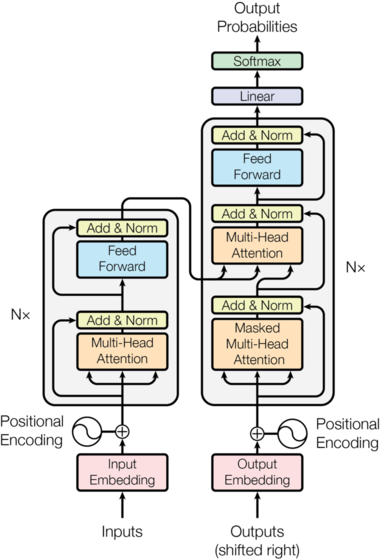

In [ ]:
class SubLayerConnection(nn.Module):

    def __init__(self, size=0.1, dropout_p=0.1):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout_p)
    
    def forward(self, x, sublayer):
        x_new = self.norm(x)
        x_new = sublayer(x_new)
        x_new = self.dropout(x_new)
        return x + x_new


class FeedForwardLayer(nn.Module):

    def __init__(self, d_k, hidden):
        super().__init__()
        self.linear1 = nn.Linear(d_k, hidden)
        self.linear2 = nn.Linear(hidden, d_k)
        self.relu = nn.Relu()
    
    def forward(self, x):
        """Apply residual connection"""
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x


class MultiHeadAttention(nn.Module):

    def __init__(self, dk=512, h=8):
        self.dk = dk
        self.h = h
        self.d = self.dk // self.h
        self.q_linear = nn.Linear(dk, dk)
        self.k_linear = nn.Linear(dk, dk)
        self.v_linear = nn.Linear(dk, dk)
        self.linear = nn.Linear(dk, dk)

    def forward(self, q, k, v, mask=None):
        n_batch = q.size[0]

        # q: (batch_size, input_len, h, d_k//h)
        # q: (batch_size, h, input_len, dk//h) # for each batch_size, for each head: ..

        q = q.view(n_batch, -1, self.h, self.d).transpose(-2, -3)
        k = k.view(n_batch, -1, self.h, self.d).transpose(-2, -3)
        v = v.view(n_batch, -1, self.h, self.d).transpose(-2, -3)

        q = self.q_linear(q) # q: (batch, h, input_len, d)
        k = self.k_linear(k) # k: (batch, h, input_len, d)
        v = self.v_linear(v) # v: (batch, h, input_len, d)

        x, self.attn = attention(q, k, v, mask)
        x = self.linear(x)
        return x


class EncoderLayer(nn.Module):
    """
    Each encoder block contains following items:
    1. 1 * multi-head attention
    2. 2 * add & norm (subLayerConnection)
    3. 1* feedforward 
    """

    def __init__(
        self,
        size,
        self_attn: MultiHeadAttention,
        feed_forward: FeedForwardLayer,
        dropout: float
    ):
        self.norm = LayerNorm()
        self.feed_forward = feed_forward
        self.self_attn = self_attn
        self.size = size
        self.sublayer_connections = nn.ModuleList([SubLayerConnection() for _ in range(2)])
    
    def forward(self, x, src_mask):
        """
        Encoder will need src mask to masking out the <pad> token to avoid
        attention interaction between normal token and <pad> token.
        """
        x = self.sublayer_connections[0](x, lambda x: self.self_attn(x, x, x, src_mask))
        x = self.sublayer_connections[1](x, self.feed_forward)
        return x

# Encoder

In [ ]:
class Encoder(nn.Module):

    def __init__(self, n=6, dk=512):
        self.norm = LayerNorm(dk)

        self.layers = nn.ModuleList(
            [
                EncoderLayer(dk, MultiHeadAttention(dk), FeedForwardLayer(dk, 20))
                for i in range(n)
            ]
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

# Decoder Block


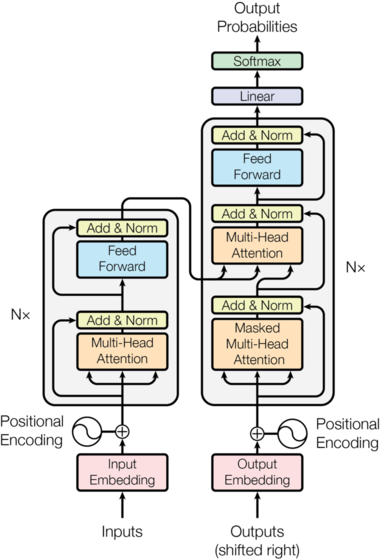

For decoding layer it will be slightly more complex than the encoder layer


Input:
- It receive output token and it will act as query matrix
- for each block, it will receive the contextual representation of source sentences as key and value
    - notice that this key, value matrix will contain the information from source sentence and it will act as a memory bank. Later on, when we generate token, the token will serve as query matrix, to query our memory bank

Masked Attention:
- Attention will be masked to follow the auto-regressive natural since trg sentence will be feed into decoder as an entire sentences

Loss function:
- we computed the predicted probability distribution and we need to approximate the predicted probaility distribution to target distribution -> in this case, we can use cross entropy to compute the loss where each word token is a category (minimize the distance between predicted distribution and true distribution.)

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self, dk):
        self.dk = dk
        self.self_attn = MultiHeadAttention(dk)
        self.feed_forward = FeedForwardLayer(dk, 200)
        self.sublayer_connections = nn.ModuleList([SubLayerConnection(size=dk)] for i in range(3))
    
    def forward(self, x, encoder_output, src_mask, trg_mask):
        """Memory Bank: encoder_output"""

        x = self.sublayer_connections[0](x, lambda x: self.self_attn(x, x, x, trg_mask))
        cross_attn = lambda x: self.self_attn(x, encoder_output, encoder_output, src_mask)
        x = self.sublayer_connections[1](x, cross_attn(x))
        x = self.sublayer_connections[2](x, self.feed_forward(x))
        return x

# Decoder & Generator

In [ ]:
class Decoder(nn.Module):

    def __init__(self, n, dk):
        self.norm = LayerNorm(dk)
        self.layers = nn.ModuleList([DecoderLayer(dk) for i in range(n)])

    def forward(self, x, encoder_output, src_mask, trg_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, trg_mask)
        return self.norm(x)

In [ ]:
class Generator(nn.Module):

    def __init__(self, d_model, vocab):
        self.d_model = d_model
        self.linear = nn.Linear(d_model, vocab)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, x):
        out = self.linear(x) # x: (nbatch, input_len, d_model), out: (nbatch, input_len, vocab)
        res = self.softmax(out, dim=-1) # output predicted probability distribution
        return res

# Encoder, Decoder & Generator


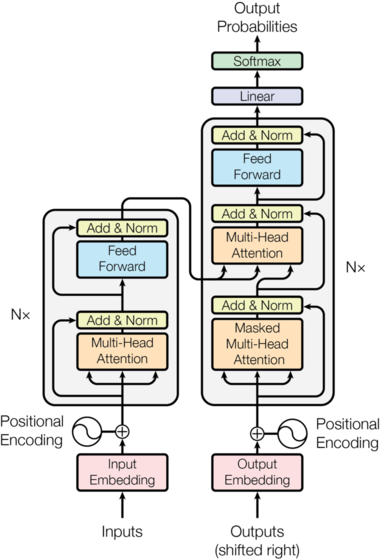

In [ ]:
class EncoderDecoder(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, generator: Generator, src_emb, trg_emb):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator
        self.src_emb = src_emb
        self.trg_emb = trg_emb
    
    def forward(self, x, src_mask, trg_mask):
        encoder_output = self.encode(x, src_mask) #  contains <pad> mask
        out = self.decode(x, encoder_output, src_mask, trg_mask)
        return out

    def encode(self, x, src_mask):
        src_emb = self.src_emb(x)
        out = self.encoder(src_emb, src_mask)
        return out

    def decode(self, x, encoder_output, src_mask, trg_mask):
        trg_emb = self.trg_emb(x)
        out = self.decoder(trg_emb, encoder_output, src_mask, trg_mask)
        return out

In [ ]:
def construct_model():

    encoder = Encoder()
    decoder = Decoder()
    generator = Generator()

    src_emb = ... # token embedding + pos embedding
    trg_emb = ... # token embedding + pos embedding

    transformer = EncoderDecoder(
        encoder=encoder,
        decoder=decoder,
        generator=generator,
        src_emb=src_emb,
        trg_emb=trg_emb
    )
    return transformer